# Homework Lecture 2:

### 1.0 Setup

In [1]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 1.1 writing a function to simulate an AR(1) process

To make our job a little easier, let's write a couple of functions that allow us to simulate the AR(1) process and to compute the ACF for the desired lags. This is useful, as it avoids duplicate code. To solve the individual exercises, we then simply have to call the functions with different input arguments.

In [2]:
def AR_simul(T, α, β, μ, σ, y_0):
    
    # initialize the output vector
    Y = np.empty(T+1)
    
    # set the starting value
    Y[0] = y_0
    
    # simulate the AR(1) process
    for i in range(T):
        Y[i+1] = α + β*Y[i] + μ + σ* np.random.randn()
        
        # return the T simulated values without the starting value
    return Y[1:]


To compute the ACF for desired lags, we need to design a function that takes the time series as well as a list of lags (for which we want to compute the ACF) as inputs. The single output argument then simply contains the list of ACF values for the pre-specified lags. 

In [3]:
def autocorr(x,lags=[1]):
    # the lags=[1] sets the default to 1. If no input is given, the function will return the ACF for the 1st lag
    # initilalize the acf vector
    acf = []
    
    # compute the ACF for the desired lags
    for i in lags:
        # compute acf for lag lengths given in l
        ac = np.corrcoef(np.array([x[:-i], x[i:]]))
        
        # extract the upper corner element of the ac matrix
        ac = ac[np.triu_indices(ac.shape[0], k = 1)]
        
        # collect the ACF for all l 
        acf.append(ac.tolist())
    
    # flatten the list of lists into a list
    acf = [item for sublist in acf for item in sublist]
    return acf


In the following exercises, we can now simply call these two functions instead of having to replicate code. 

### a)  

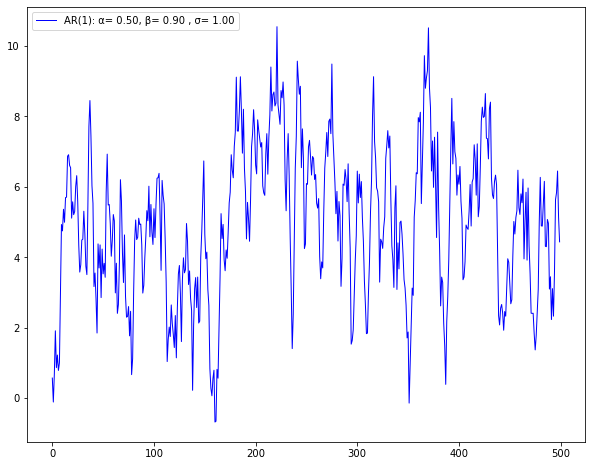

In [4]:
# initialize the coefficients 
T = 500
α = 0.5
β = 0.9
μ = 0
σ = 1
y_0 = 0

# simulate the time-series by calling the simulation function
Y1 = AR_simul(T, α, β, μ, σ, y_0)

# plot the simulated time series
fig, ax = plt.subplots()
ax.plot(Y1, 'b-', linewidth=1, label='AR(1): α= %.2f, β= %.2f , σ= %.2f' %(α, β, σ) )
ax.legend()
plt.show()


With this equipped, we can now simply compute the ACF for the desired lags.

In [5]:
# call the autocorrelation function to compute the autocorrelation coefficient for l=1,5,10
Y1_acf = autocorr(Y1,[1,5,10])
Y1_acf

[0.8734733394763786, 0.42035338153122614, 0.145243932853644]

### b)

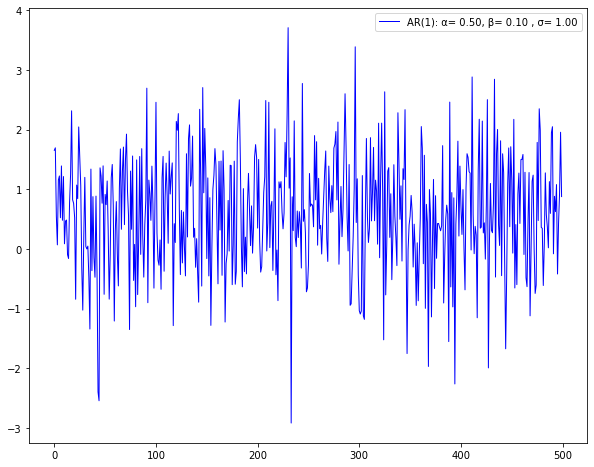

In [6]:
# initialize the coefficients
T = 500
α = 0.5
β = 0.1
μ = 0
σ = 1
y_0 = 0

# simulate the time-series by calling the simulation function
Y2 = AR_simul(T, α, β, μ, σ, y_0)

# plot the simulated time series
fig, ax = plt.subplots()
ax.plot(Y2, 'b-', linewidth=1, label='AR(1): α= %.2f, β= %.2f , σ= %.2f' %(α, β, σ) )
ax.legend()
plt.show()

In [7]:
# call the autocorrelation function to compute the autocorrelation coefficient for l=1,5,10
Y2_acf = autocorr(Y2,[1,5,10])
Y2_acf

[0.050069983066782384, -0.07530866208611627, 0.09919621523316734]

As we can see, the autocorrelation of the first process is much stronger. The process is hence more persistent. This makes intuitive sense. The higher $\beta$, the more of last period's value carries over to the current period.

Also notice that the estimate of the ACF for the first lag should actually be equal to $\beta$. For small T, however, this estimate seems to be off by quite a bit. If we increase the simulated time series length, the estimate should actually converge to the true $\beta$. Try it for yourselves.

### c)

Before jumping into the final exercise, let's recycle some code from last lecture's solutions and convert it into a class. Classes are an essential part of Python's object-based programming features that make it easier to recognize and exploit common data structures.

In [8]:
class OLS:

    """
    This code implements a simple OLS regression. The inputs Y and X must be in numpy matrix format. 
    """
    
    def __init__(self, Y, X):
        #Initialize the dependent and independent variables
        self.Y, self.X = Y, X 
        
        # terminate and produce error message, if Y or X are of wrong type
        if isinstance(X,np.ndarray) == False:
            raise TypeError('X is not a numpy ndarray!')
        if isinstance(Y,np.ndarray) == False:
            raise TypeError('Y is not a numpy ndarray!')

    def estimate(self):
        #unpack Y and X
        Y, X = self.Y, self.X
        
        #Estimate the beta coefficients
        self.beta = np.linalg.inv(X.T @ X) @ (X.T @ Y)
        
        #compute the regression residuals
        eps = Y - X @ self.beta
        
        #compute the residual variance
        s_hat = 1/(Y.shape[0]-self.beta.shape[0]) * eps.T @ eps
        
        #compute the standard errors
        self.se = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * s_hat.item())).reshape((self.beta.shape[0],1))
        
        #compute t-statistic for standard hypothesis test
        t = np.abs(self.beta/self.se)

        #compute p-values for standard hypothesis test
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
             
        #compute confidence intervals
        CI_upper = self.beta + stats.norm.ppf(0.975)*self.se
        CI_lower = self.beta - stats.norm.ppf(0.975)*self.se
        
        #generate an output table
        outmat = np.hstack((self.beta,self.se,t,p_vals,CI_lower,CI_upper))
        table = pd.DataFrame(outmat)
        table.columns =['beta', 'se','t-statistic','p-value','CI - lower','CI - upper'] 
        
        return table
    
    def hypothesis_test(self,i,β_0):
        # here a small if statement tests whether estimates have been computed before. If not, we simply call the
        # "estimate" function of our class
        if hasattr(self, 'beta'):
            beta, se = self.beta, self.se
            print("Previous estimates available. Hypothesis test is conducted based on previous estimates.")
        else:
            self.estimate()
            beta, se = self.beta, self.se
            print("No previous estimates available. Estimating OLS to obtain coefficients.")
        
        
        # compute the test statistic
        t = np.abs((beta[i] - β_0)/se[i])
        
        #compute p-values
        p_vals = 2*(1-stats.norm.cdf(np.abs(t)))
        
        # create output table
        outmat = np.vstack((t,p_vals))
        table = pd.DataFrame(outmat.T)
        table.columns =['t-statistic','p-value']
        
        return table

Below we will first generate the random walk (with drift) and then use our newly created class to answer the homework question.

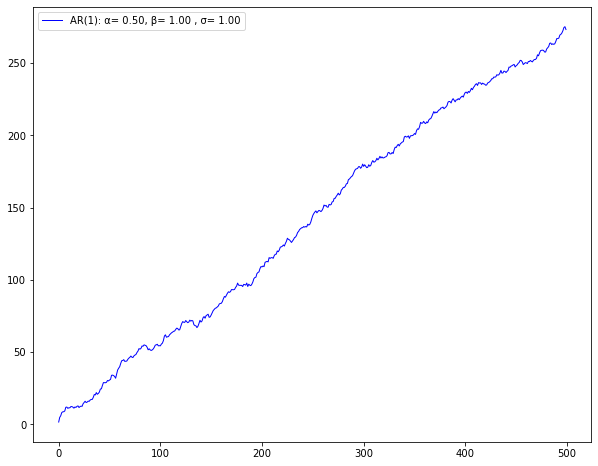

In [9]:
# initialize the time-sries coeffcients
T = 500
α = 0.5
β = 1
μ = 0
σ = 1
y_0 = 0

# simulate the random walk
Y3 = AR_simul(T, α, β, μ, σ, y_0)

# plot the simulated time series
fig, ax = plt.subplots()
ax.plot(Y3, 'b-', linewidth=1, label='AR(1): α= %.2f, β= %.2f , σ= %.2f' %(α, β, σ) )
ax.legend()
plt.show()

In [10]:
# set up the dependent and independent variable for the regression exercise. Both must be in numpy.matrix format. 
# X includes an intercept and a time trend
Y3 = np.asarray([Y3]).T
X = np.asarray([list(range(1,Y3.shape[0]+1,1))]).reshape((Y3.shape[0],1))

# add a constant
X = np.hstack((np.ones([Y3.shape[0],1]), X))

In [11]:
# here we define β_1 as an "OLS" object that takes the attributes Y3 and X. We can now simply call the functions
# that we defined before and estimate β_1 and conduct hypothesis tests
β_1 = OLS(Y3,X)

In [12]:
# call the "estimate" function on our newly defined OLS object to obtain estimates
β_1.estimate()

,beta,se,t-statistic,p-value,CI - lower,CI - upper
0,1.713634,0.487526,3.514960,0.00044,0.758101,2.669167
1,0.556411,0.001686,329.957738,0.00000,0.553106,0.559716


In [13]:
# we can also conduct a hypothesis test for any other parameter value
β_1.hypothesis_test(1,0.5)

Previous estimates available. Hypothesis test is conducted based on previous estimates.


,t-statistic,p-value
0,33.45233,0.0


Since the time series is a random walk with drift ($\alpha$ is non-zero), it is not ergodic stationary! Thus OLS will not consistently estimate the parameters and hypothesis tests are invalid. The take-away is that we have to **detrend** series that are **trend stationary (feature a deterministic trend)**, but we have to **difference** time series that have a **unit root (feature a stochastic trend)** to make either time-series stationary. Detrending e.g. a random walk with drift, will not render the resulting series stationary! 